In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import simplejson as json

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields 
from magrec.misc.data import Data

from magrec import __datapath__

In [3]:
# load json file
data = json.load(open(__datapath__ / "experimental" / "Magnetisation out of plane" / 'CrI3_Exp_B_20180622_001.json'))

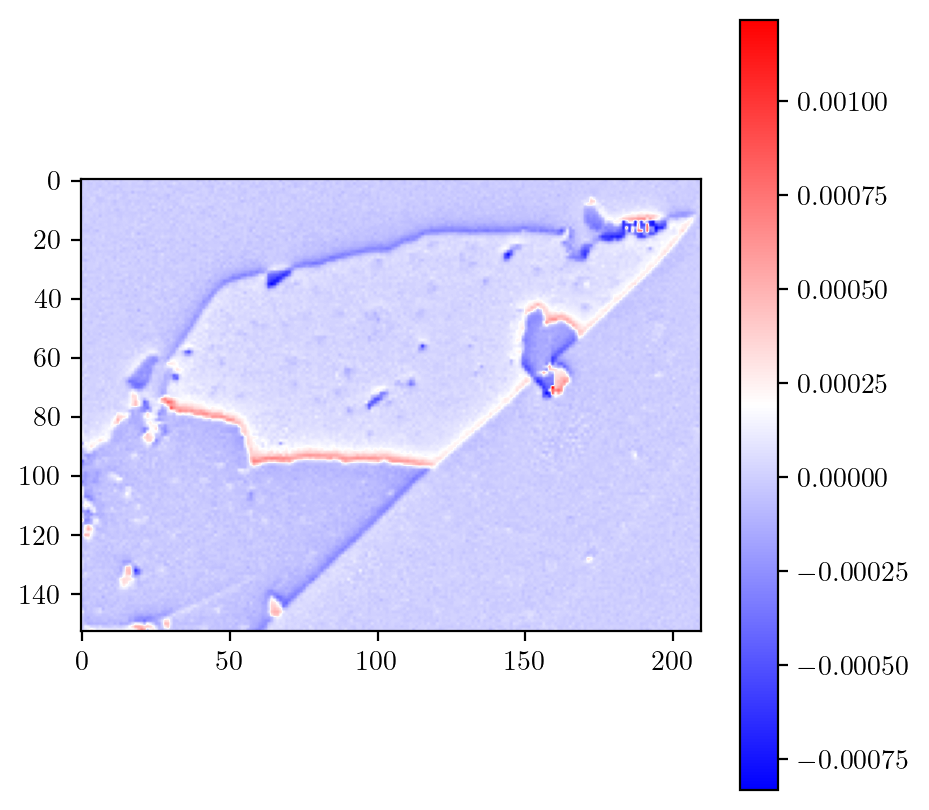

In [7]:
BNV = data["ExperimentMagneticField"]["BNV"]["Data"]

height = data["ExperimentMagneticField"]["BNV"]["Height"]
phi = data["ExperimentMagneticField"]["BNV"]["Phi"]
theta = data["ExperimentMagneticField"]["BNV"]["Theta"]

dx = 50e-9
dy = 50e-9

plt.figure(figsize=(5, 5))
plt.imshow(BNV, cmap="bwr")
plt.colorbar()

# Bx = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bx.txt")
# By = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "By.txt")
# Bz = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bz.txt")

# B = np.empty(shape=(3, 201, 201))

# B[0, ::] = np.flipud(Bx)
# B[1, ::] = np.flipud(By)
# B[2, ::] = np.flipud(Bz)

# plot_n_components(BNV, cmap="bwr")


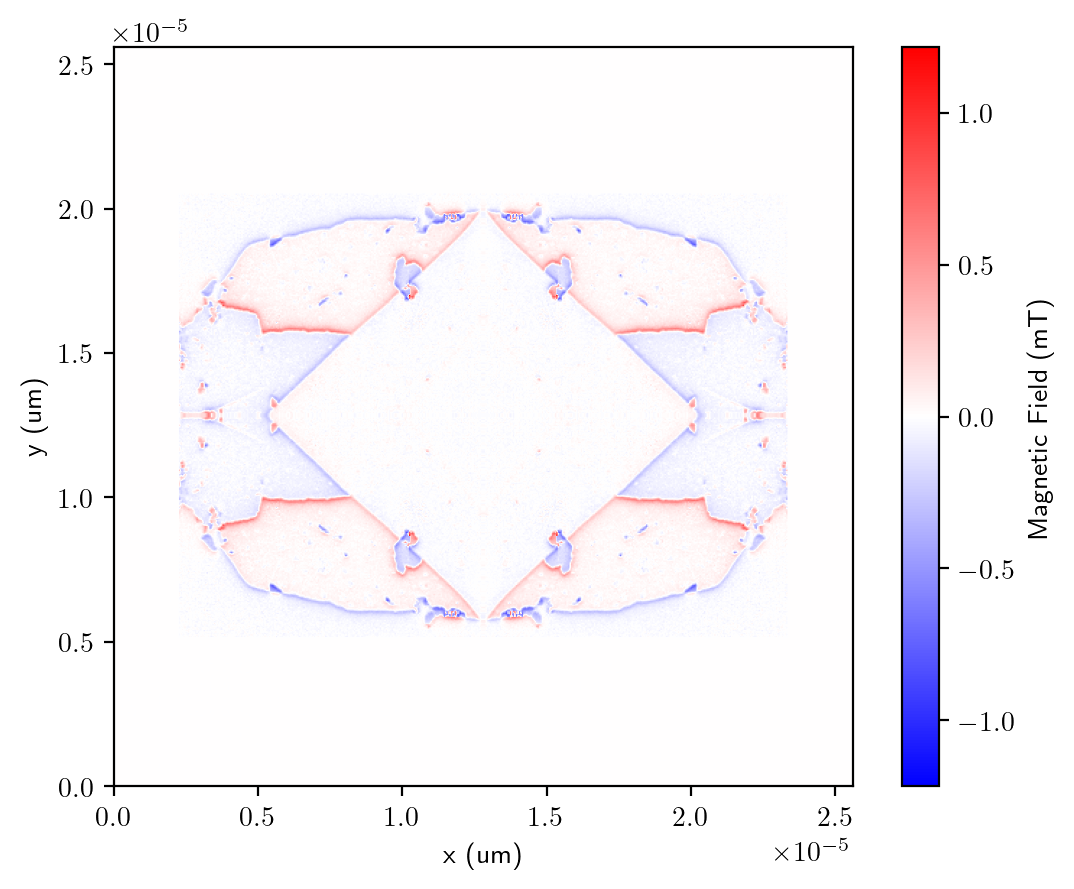

In [19]:


dataset = Data()
dataset.load_data(
       BNV, 
       dx, 
       dy, 
       height, 
       theta, 
       phi, 
       0)

dataset.remove_DC_background()

# dataset.add_hanning_filter(0.4)
# dataset.crop_data((1,198,1,198))

# dataset.numpy_pad_data(200, 'constant')
dataset.pad_reflective2d()
dataset.pad_data_to_power_of_two()
# dataset.pad_reflective2d()

dataset.plot_target()

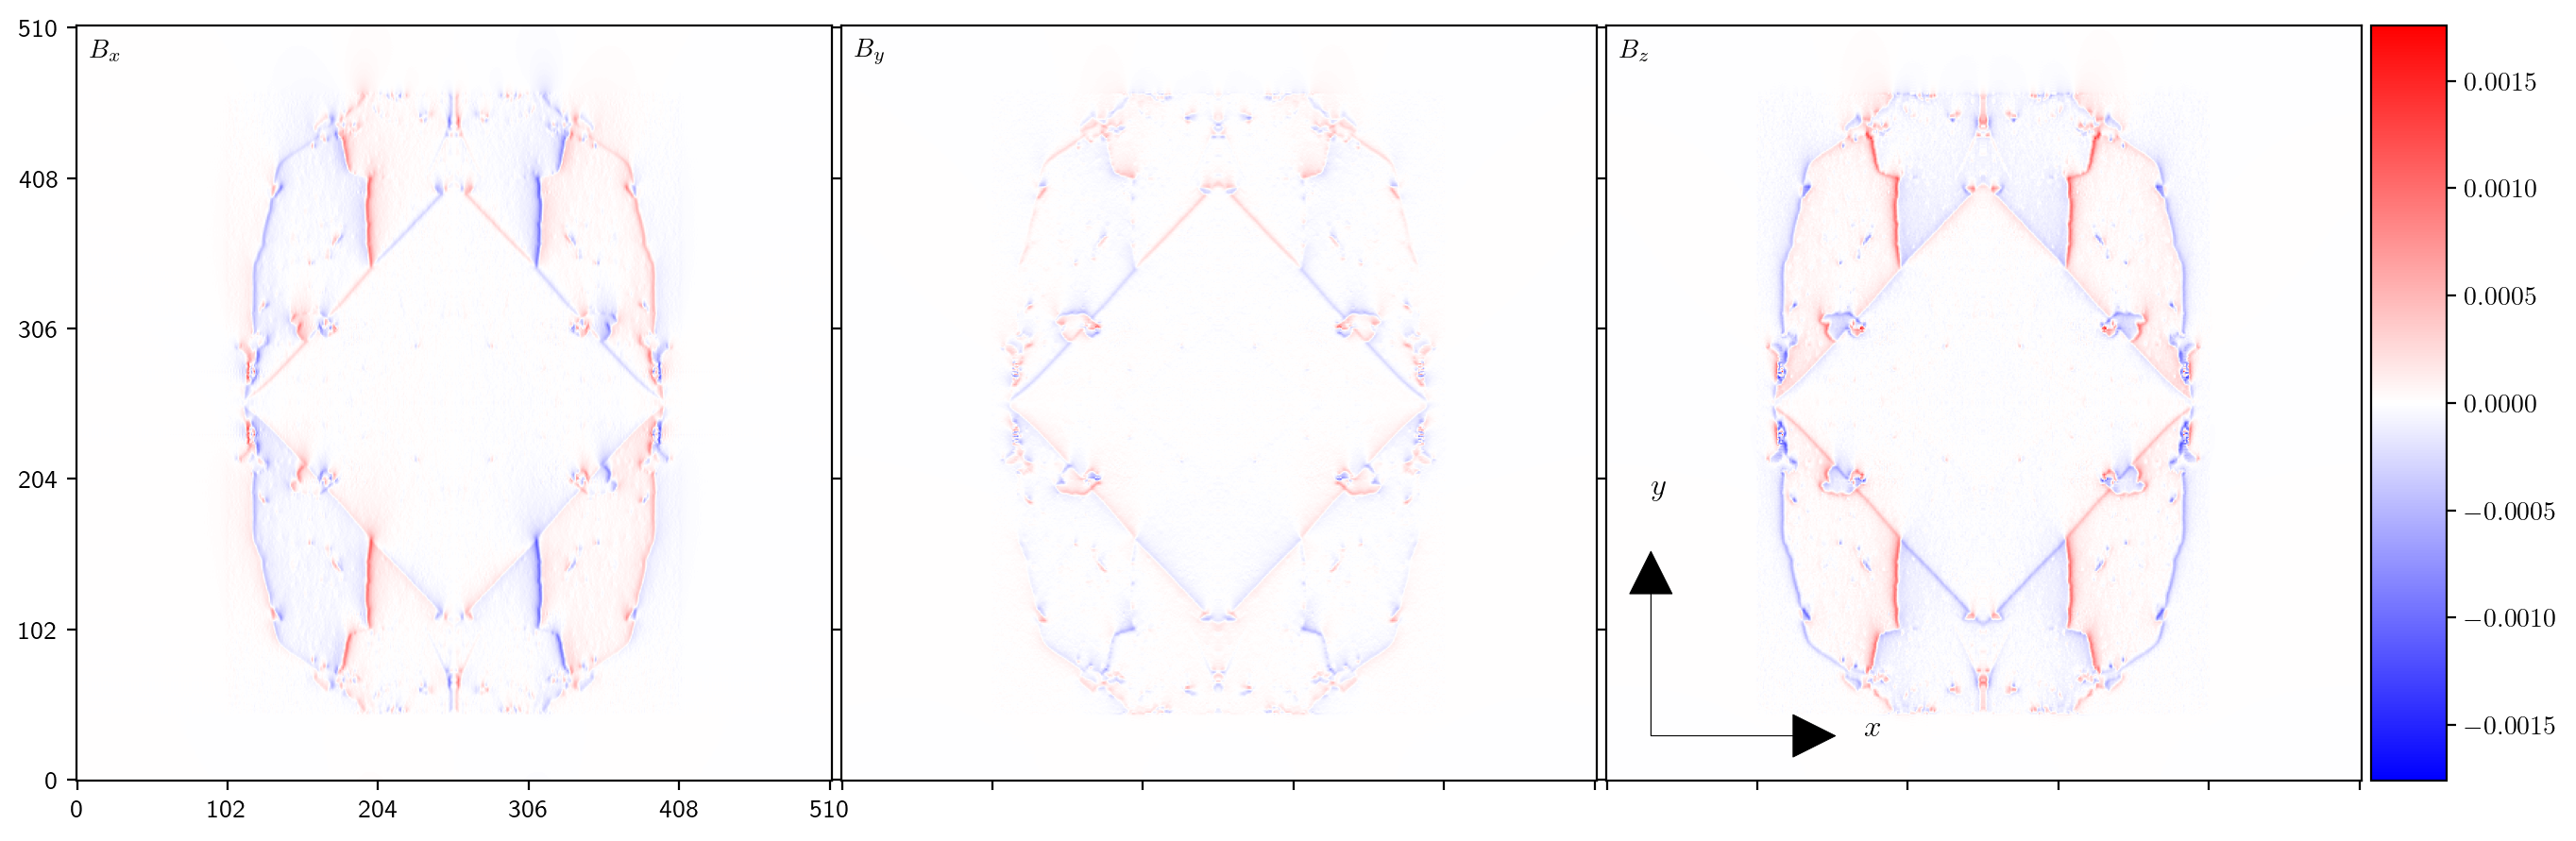

In [20]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

# plot the reconstructed magnetic field
plot_n_components(dataset.transformed_target, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")

Removed the padding that was applied to the data
Removed the padding that was applied to the data
Removed the padding that was applied to the data


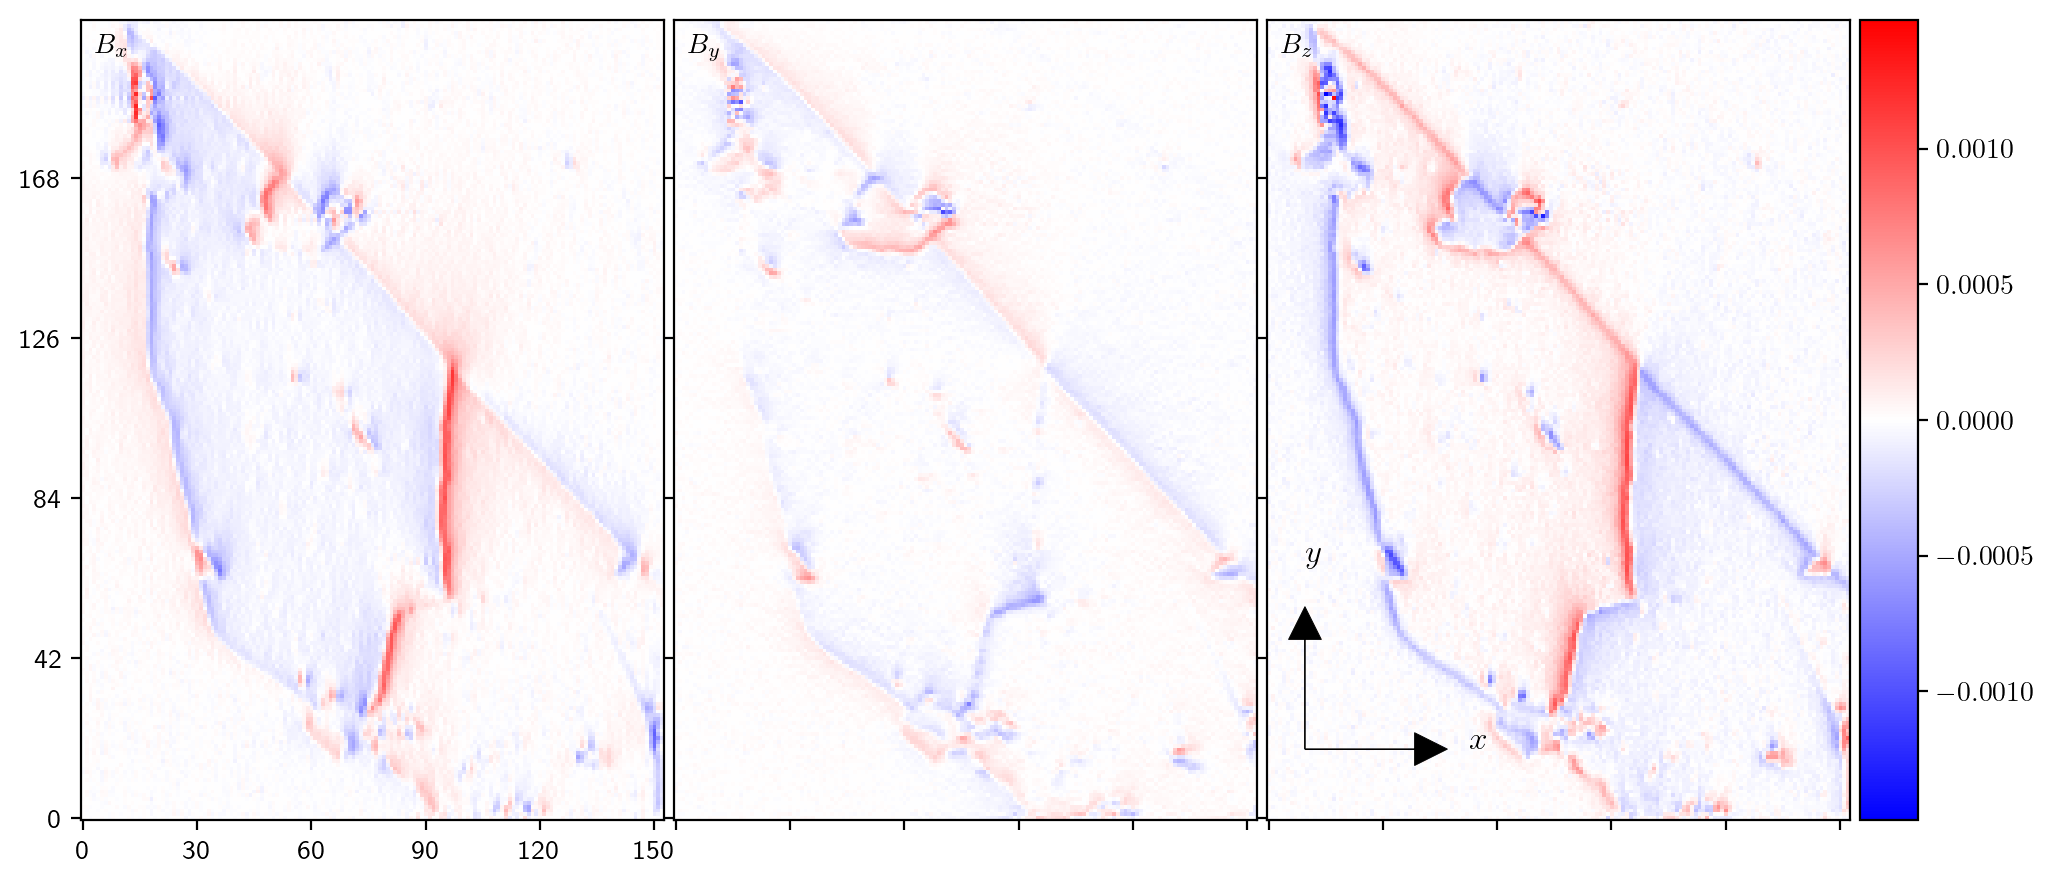

In [22]:
Bx_recon = dataset.remove_padding_from_results(dataset.transformed_target[0, ::])
By_recon = dataset.remove_padding_from_results(dataset.transformed_target[1, ::])
Bz_recon = dataset.remove_padding_from_results(dataset.transformed_target[2, ::])

# collect for plotting 
B_recon = np.empty(shape=(3, 153, 210))
B_recon[0, ::] = Bx_recon
B_recon[1, ::] = By_recon
B_recon[2, ::] = Bz_recon

# plot the reconstructed magnetic field
plot_n_components(B_recon, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")

## Background substraction

Above we see that $J_x$, $J_y$ reconstruction has artifacts in a form of sort of background offsets. $J_y$ artifact is in the form of a background constant spatial DC offset, whereas $J_x$ is a more complicated one: Maybe it can be corrected by a plane $J_{x, \text{offset}} = ax + by$? 

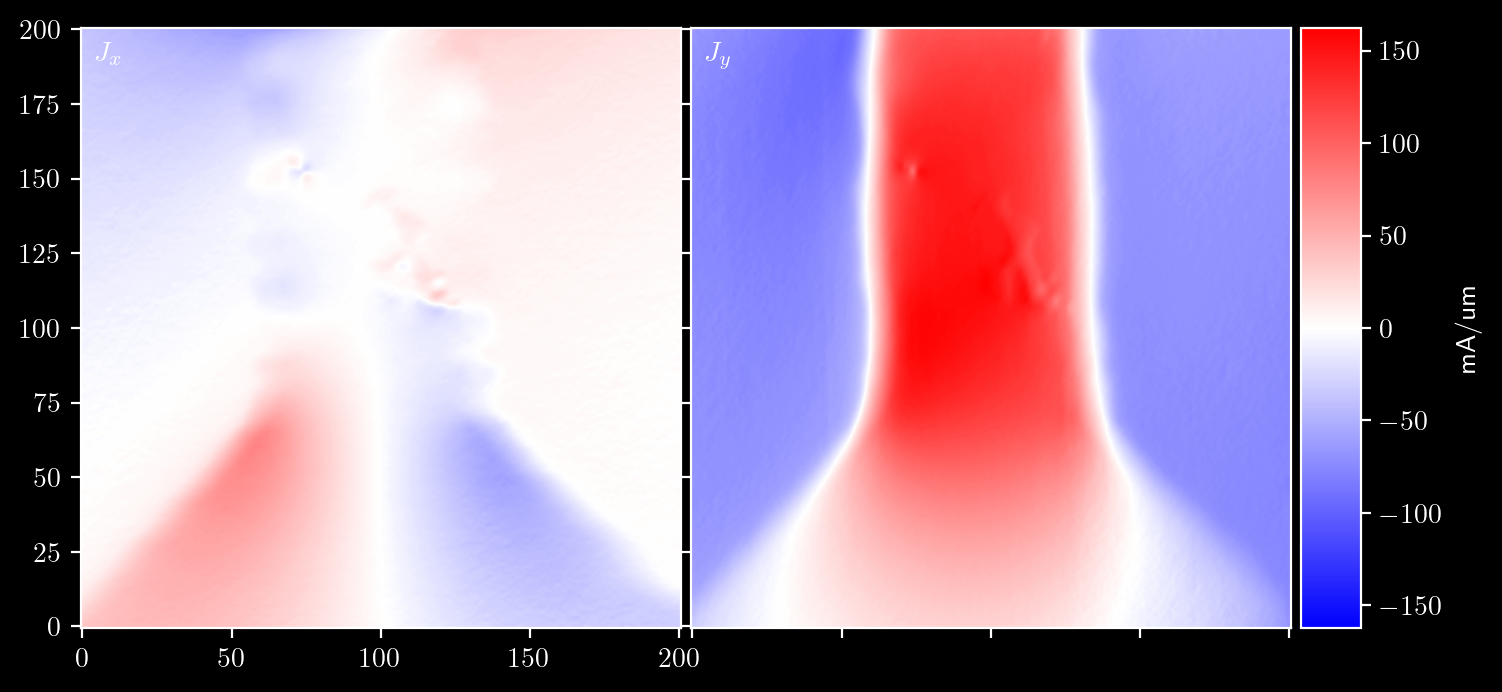

In [136]:
# there is a wrong way to correct the current density by subtracting the mean of each component across the image
# plotting the result, we see that the effect is not becaucase of the mean shift
def wrong_correct_background(J: torch.tensor):
    J = J - J.mean(dim=(-2, -1), keepdim=True)
    return J

plot_n_components(wrong_correct_background(JxJy[:,100:301,100:301]), symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "interpolation": "bicubic",
    })


In [137]:
def correct_background(J: torch.tensor):
    # that's the region where J_y component should be zero but it is not
    Jy_zero_region = J[1, 150:200, 150:200]
    Jy_offset = Jy_zero_region.mean()

    Jx_zero_region_1 = J[0, 0:50, 150:200]
    Jx_offset_1 = Jx_zero_region_1.mean()

    Jx_zero_region_2 = J[0, 150:200, 150:200]
    Jx_offset_2 = Jx_zero_region_2.mean()
    
    # for J_x component, we want to correct for a linear variation so that the values for the Jx_offset 
    # vary from Jx_offset_1 to Jx_offset_2 across the width of the image
    Jx_offset = torch.linspace(Jx_offset_1, Jx_offset_2, J.shape[-2])
    J[0, :, :] = J[0, :, :] - Jx_offset[:, None]
    J[1, :, :] = J[1, :, :] - Jy_offset
    plot_n_components(J, symmetric=True, cmap="bwr", show=True)
    return J

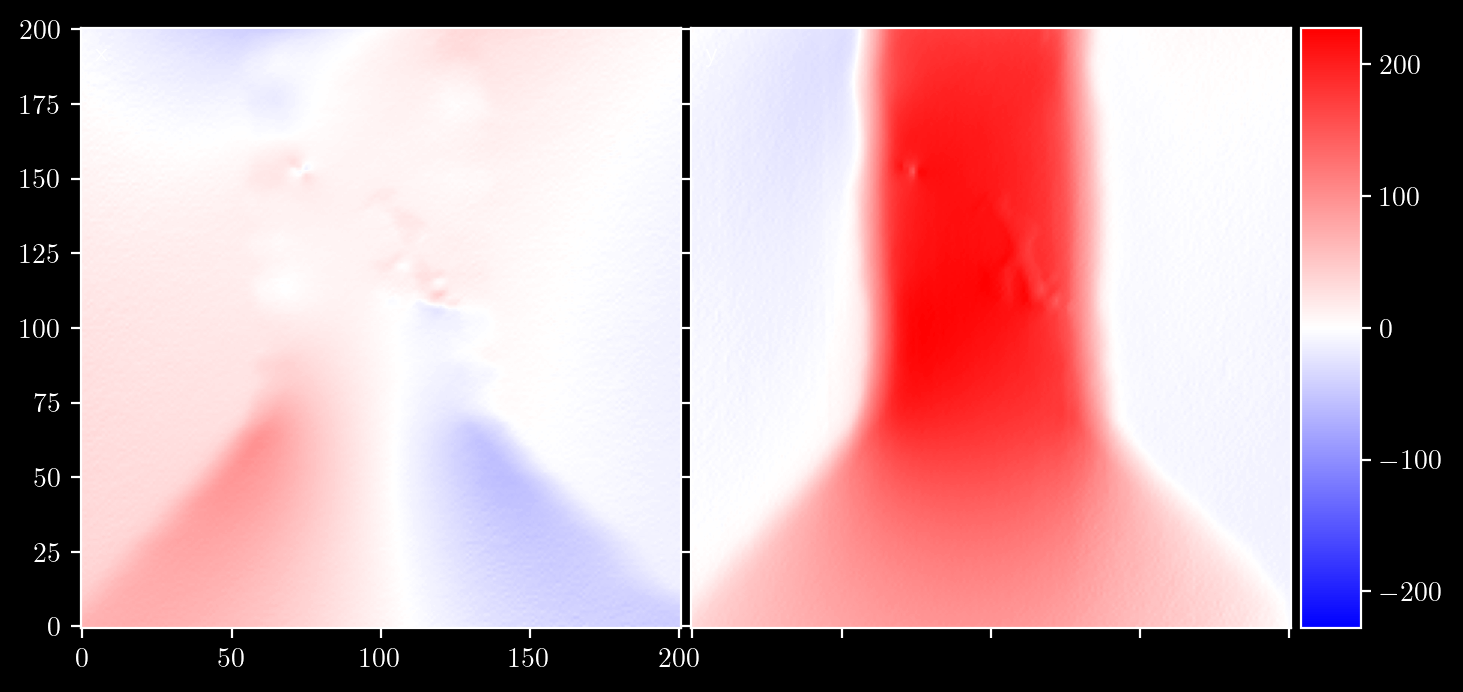

In [138]:
J_corrected = correct_background(JxJy[:,100:301,100:301])

Check that the reconstructed current produces the expected magnetic field. For that, take `JxJy` and input it into a reasonable propagator algorithm to obtain $B$ field.



In [139]:
from magrec.prop.Propagator import HeightContinuationPadder, ZeroPadder, CurrentPropagator2d, AxisProjectionPropagator

In [140]:
shape = J_corrected.shape
pad1 = HeightContinuationPadder(shape=shape)
pad2 = ZeroPadder(shape=pad1.expanded_shape)
propagator = CurrentPropagator2d(source_shape=pad2.expanded_shape,
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)
proj = AxisProjectionPropagator(theta=theta, phi=phi)

def compute_B(J: torch.tensor):
    J = pad1.pad(J)
    fig = plot_n_components(J, symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", show=True)
    fig.suptitle("Padded J", y=0.86)
    J = pad2.pad(J)
    B = propagator(J)
    B = pad2.unpad(B)
    B = pad1.unpad(B)
    B_NV = proj.project(B)
    B = torch.concat((B, B_NV[None, ...]), dim=0)
    return B


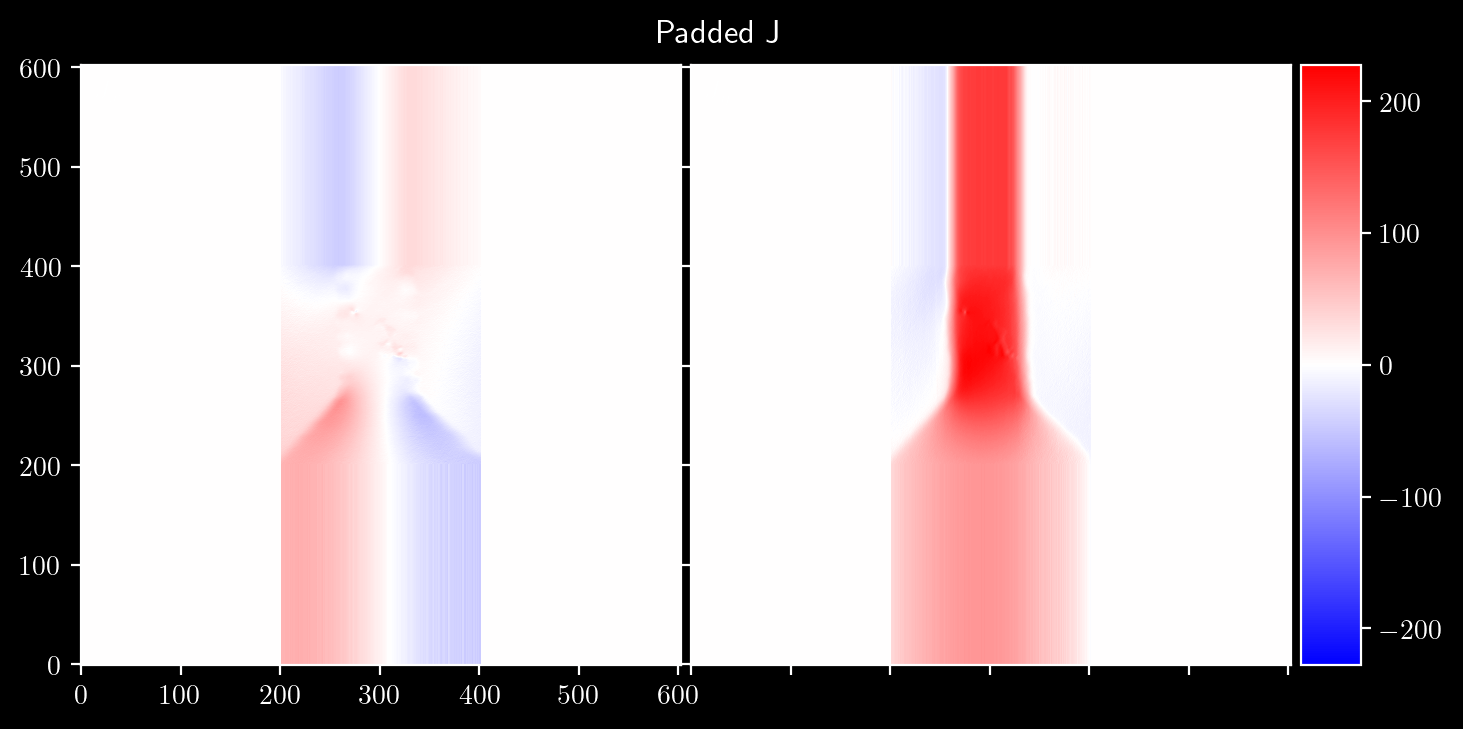

In [141]:
reconstructedB = compute_B(J_corrected)

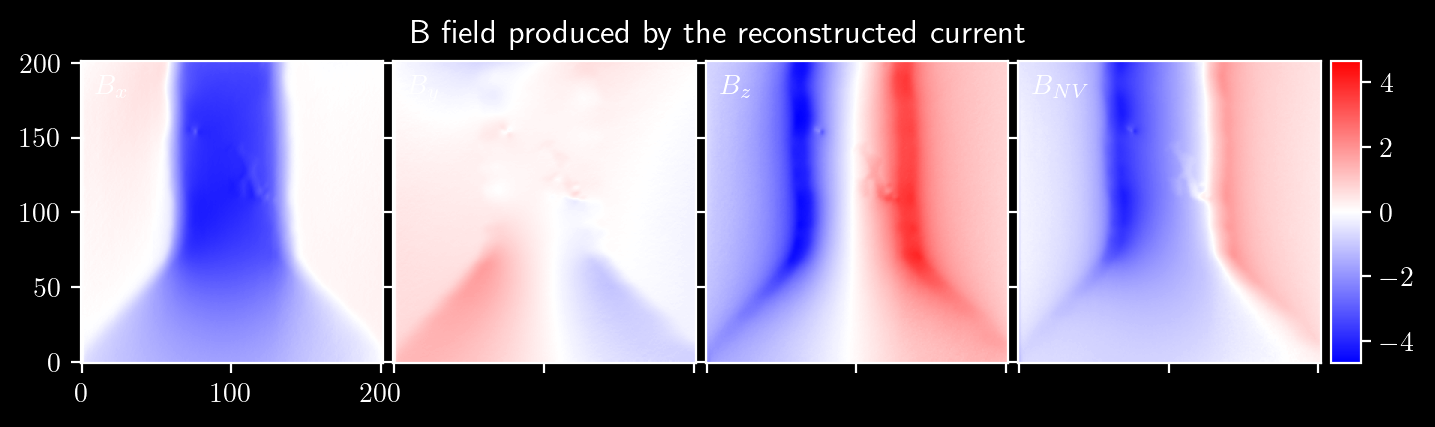

In [142]:
fig = plot_n_components(reconstructedB, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")
fig.suptitle("B field produced by the reconstructed current", y=0.7)
fig

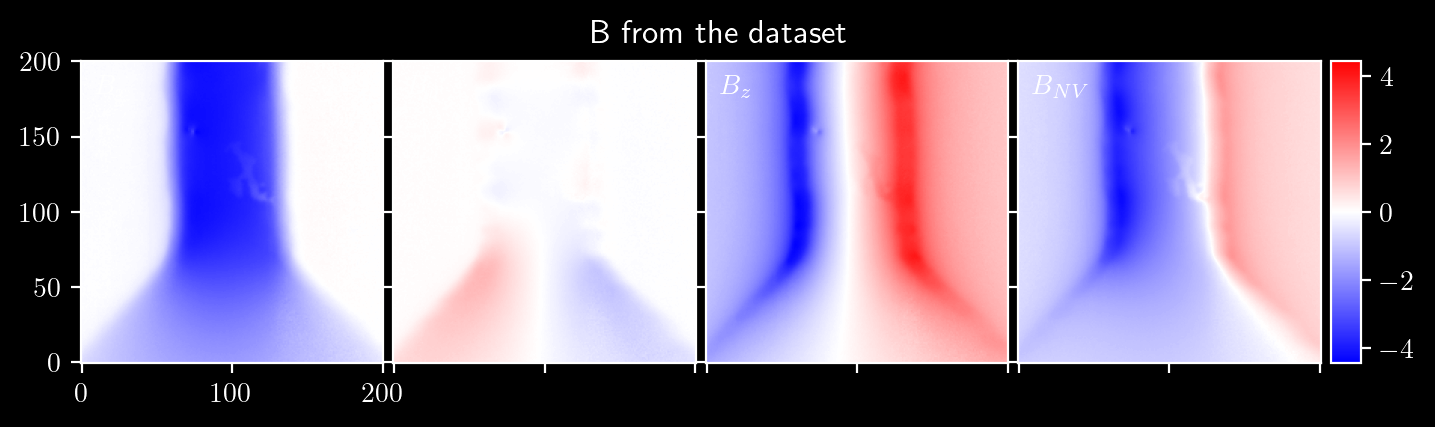

In [143]:
fig = plot_n_components(B, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")
fig.suptitle("B from the dataset", y=0.7)
fig